In [52]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [16]:
#import sklearn.cluster.k_means_ as Kmeans
from sklearn.cluster import KMeans
from keras.datasets import mnist
from keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score
import numpy as np
from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.layers import Dense, Input
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
import keras.backend as K
#import metrics
from skimage.io import imread_collection
import cv2
import glob
import skimage.color as color

In [2]:
save_dir = 'weights'

In [3]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc2(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

### Get Data

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))[:5000]
y = np.concatenate((y_train, y_test))[:5000]
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)

In [9]:
x_train[1].shape, x[1].shape

((28, 28), (784,))

In [20]:
train = []
files = glob.glob ("train_images/subset_10/*.jpg") # your image path
for myFile in files:
    image = cv2.imread (myFile)
    image_gray = color.rgb2gray(image)
    train.append (image_gray)
train = np.array(train,dtype='float32')

test = []
files = glob.glob ("test_images/subset_10/*.jpg") # your image path
for myFile in files:
    image = cv2.imread (myFile)
    image_gray = color.rgb2gray(image)
    test.append (image_gray)
test = np.array(test,dtype='float32')
    
x = np.reshape(train,[train.shape[0],train.shape[1]*train.shape[2]])#*train.shape[3]])
y = np.reshape(test,[test.shape[0],test.shape[1]*test.shape[2]])#*test.shape[3]])

#x = imread_collection('train_images/*.jpg')
#y = imread_collection('test_images/*.jpg')
#x = np.concatenate((x_train, x_test))[:5000]
#y = np.concatenate((y_train, y_test))[:5000]
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
x[1].shape, train[1].shape

((9170640,), (2710, 3384))

In [14]:
2710*3384*3

27511920

### Baseline K-Means

In [88]:
#10 clusters
n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters = n_clusters, n_init = 20, n_jobs = 4)

In [89]:
# Train k-means
y_pred_kmeans = kmeans.fit_predict(x)

#Evaluate accuracy

acc=acc(y, y_pred_kmeans)
print("Accuracy score is", acc)

Accuracy score is 0.5148


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


### Autoencoder

In [90]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [91]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale = 1. / 3., mode = 'fan_in', distribution = 'uniform')
pretrain_optimizer = SGD(lr = 1, momentum = 0.9)
pretrain_epochs = 200
batch_size = 256
#save_dir = './results'

In [92]:
autoencoder, encoder = autoencoder(dims, init=init)

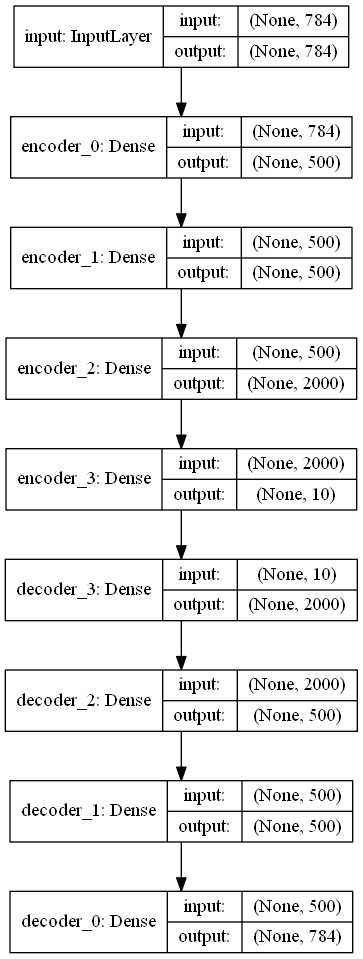

In [93]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')

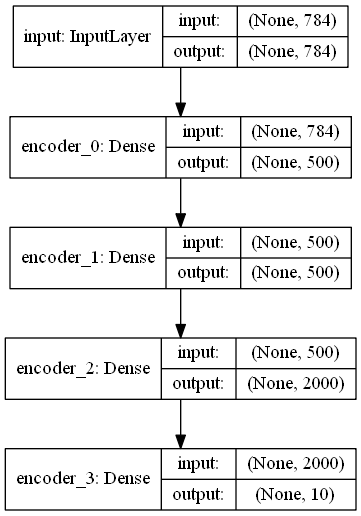

In [94]:
from keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png')

### Pretrain auto-encoder

In [95]:
autoencoder.compile(optimizer = pretrain_optimizer, loss = 'mse')
autoencoder.fit(x, x, batch_size = batch_size, epochs = pretrain_epochs)

Epoch 1/200
5000/5000 [==============================] - 2s 419us/step - loss: 0.1016
Epoch 2/200
5000/5000 [==============================] - 1s 181us/step - loss: 0.0718
Epoch 3/200
5000/5000 [==============================] - 1s 181us/step - loss: 0.0663
Epoch 4/200
5000/5000 [==============================] - 1s 184us/step - loss: 0.0640
Epoch 5/200
5000/5000 [==============================] - 1s 183us/step - loss: 0.0627
Epoch 6/200
5000/5000 [==============================] - 1s 173us/step - loss: 0.0619
Epoch 7/200
5000/5000 [==============================] - 1s 167us/step - loss: 0.0613
Epoch 8/200
5000/5000 [==============================] - 1s 171us/step - loss: 0.0609
Epoch 9/200
5000/5000 [==============================] - 1s 175us/step - loss: 0.0605
Epoch 10/200
5000/5000 [==============================] - 1s 168us/step - loss: 0.0596
Epoch 11/200
5000/5000 [==============================] - 1s 191us/step - loss: 0.0582
Epoch 12/200
5000/5000 [============================

5000/5000 [==============================] - 1s 235us/step - loss: 0.0137
Epoch 189/200
5000/5000 [==============================] - 1s 206us/step - loss: 0.0137
Epoch 190/200
5000/5000 [==============================] - 1s 228us/step - loss: 0.0136
Epoch 191/200
5000/5000 [==============================] - 1s 191us/step - loss: 0.0136
Epoch 192/200
5000/5000 [==============================] - 1s 187us/step - loss: 0.0136
Epoch 193/200
5000/5000 [==============================] - 1s 215us/step - loss: 0.0136
Epoch 194/200
5000/5000 [==============================] - 1s 214us/step - loss: 0.0136
Epoch 195/200
5000/5000 [==============================] - 1s 206us/step - loss: 0.0134
Epoch 196/200
5000/5000 [==============================] - 1s 245us/step - loss: 0.0135
Epoch 197/200
5000/5000 [==============================] - 1s 245us/step - loss: 0.0135
Epoch 198/200
5000/5000 [==============================] - 1s 195us/step - loss: 0.0134
Epoch 199/200
5000/5000 [=====================

### Save Weights

In [96]:
autoencoder.save_weights(save_dir + '/ae_weight.h5')

### Load Weights

In [97]:
autoencoder.load_weights(save_dir + '/ae_weight.h5')

------------

# BUILD CLUSTERING MODEL

### 1 - Initialize Cluster Centers Using K-Means

- Clustering layer converts input sample to soft label
- Vector that represents the probability of the sample beloning to each cluster
- Probability calculated with student's t-distribution

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.

##### Custom Clustering Layer

In [98]:
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights = None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwards['input_shape'] = (kwards.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim = 2)
        
    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype = K.floatx(), shape = (None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer = 'glorot_uniform', name = 'clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        
    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + K.sum(K.square(K.expand_dims(inputs, axis = 1) - self.clusters), axis = 2) / self.alpha)
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis = 1))
        return q
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters
    
    def get_config(self):
        config = {'n_clusters' : self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_cofig.items()) + list(config.items()))

##### Stack Clustering Layers

In [99]:
clustering_layer = ClusteringLayer(n_clusters, name = 'clustering')(encoder.output)
model = Model(inputs = encoder.input, outputs = clustering_layer)
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


kmeans = KMeans(n_clusters = n_clusters, n_init = 20)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name = 'clustering').set_weights([kmeans.cluster_centers_])

### 2 - Deep Clustering

In [100]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [101]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.001

### 3 - Start Training

In [ ]:
#from sklearn.metrics import accuracy_score as acc2
from sklearn.metrics import normalized_mutual_info_score as nmi2
from sklearn.metrics import adjusted_rand_score as ari2

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose = 0)
        p = target_distribution(q)
        
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(acc2(y, y_pred), 5)
            nmi = np.round(nmi2(y, y_pred), 5)
            ari = np.round(ari2(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), '; loss = ', loss)
            
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
    idx = index_array[index * batch_size: min((index + 1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x = x[idx], y = p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')         

C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 0: acc = 0.60580, nmi = 0.53008, ari = 0.40944 ; loss =  0


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 140: acc = 0.62080, nmi = 0.54101, ari = 0.42878 ; loss =  0.04204


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 280: acc = 0.63220, nmi = 0.56094, ari = 0.44843 ; loss =  0.11838


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 420: acc = 0.64000, nmi = 0.57250, ari = 0.45904 ; loss =  0.1593


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 560: acc = 0.64660, nmi = 0.58273, ari = 0.46898 ; loss =  0.16733


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 700: acc = 0.65200, nmi = 0.59147, ari = 0.47701 ; loss =  0.16461


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 840: acc = 0.65500, nmi = 0.59642, ari = 0.48131 ; loss =  0.1586


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 980: acc = 0.65760, nmi = 0.59927, ari = 0.48432 ; loss =  0.15234


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1120: acc = 0.65720, nmi = 0.59965, ari = 0.48388 ; loss =  0.14677


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1260: acc = 0.65800, nmi = 0.59937, ari = 0.48399 ; loss =  0.14176


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1400: acc = 0.65740, nmi = 0.59952, ari = 0.48362 ; loss =  0.13726


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1540: acc = 0.65760, nmi = 0.59974, ari = 0.48380 ; loss =  0.13292


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1680: acc = 0.65740, nmi = 0.59962, ari = 0.48361 ; loss =  0.12903
delta_label  0.0004 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1820: acc = 0.65740, nmi = 0.59941, ari = 0.48358 ; loss =  0.12535


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 1960: acc = 0.65720, nmi = 0.59917, ari = 0.48341 ; loss =  0.12193


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2100: acc = 0.65740, nmi = 0.59927, ari = 0.48361 ; loss =  0.11916
delta_label  0.0008 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2240: acc = 0.65740, nmi = 0.59936, ari = 0.48348 ; loss =  0.11653
delta_label  0.0004 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2380: acc = 0.65740, nmi = 0.59925, ari = 0.48350 ; loss =  0.11403
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2520: acc = 0.65760, nmi = 0.59949, ari = 0.48380 ; loss =  0.11172
delta_label  0.0004 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2660: acc = 0.65760, nmi = 0.59949, ari = 0.48380 ; loss =  0.10961
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2800: acc = 0.65760, nmi = 0.59949, ari = 0.48380 ; loss =  0.10765
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 2940: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.10583
delta_label  0.0004 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3080: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.10415
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3220: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.10264
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3360: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.10131
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3500: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.10025
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3640: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.09939
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3780: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.09778
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 3920: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.09731
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4060: acc = 0.65780, nmi = 0.59991, ari = 0.48414 ; loss =  0.09931
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4200: acc = 0.65760, nmi = 0.59965, ari = 0.48393 ; loss =  0.09222
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4340: acc = 0.65740, nmi = 0.59939, ari = 0.48373 ; loss =  0.09238
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4480: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.09129
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4620: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.09038
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4760: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08952
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 4900: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08877
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5040: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.088
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5180: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08737
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5320: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08685
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5460: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08642
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5600: acc = 0.65740, nmi = 0.59947, ari = 0.48379 ; loss =  0.08603
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5740: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.08558
delta_label  0.0002 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 5880: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.0851
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6020: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.08424
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6160: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.08294
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6300: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.08129
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
C:\Users\dandoye\Anaconda3\envs\deepLearning\lib\site-packages\sklearn\metrics\cluster\supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


Iter 6440: acc = 0.65740, nmi = 0.59950, ari = 0.48382 ; loss =  0.08014
delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


### 4 - Load Clustering Model Weights

In [ ]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### 5 - Final Evaluation

In [ ]:
q = model.predict(x, verbose = 0)
p = target_distribution(q)

y_pred = q.argmax(1)
if y is not None:
    acc = np.round(acc2(y, y_pred), 5)
    nmi = np.round(nmi2(y, y_pred), 5)
    ari = np.round(ari2(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

### 6 - Accuracy Metric

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Alternatives

In [36]:
# Input placeholder
input_img = Input(shape=(784,))

# "encoded" is the encoded representation of the input
encoded = Dense(2000, activation='relu')(input_img)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(500, activation='relu')(encoded)
encoded = Dense(10, activation='sigmoid')(encoded)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(500, activation='relu')(encoded)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(2000, activation='relu')(decoded)
decoded = Dense(784)(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [ ]:
autoencoder.fit(x, x, batch_size = 32, epochs = 10)
autoencoder.save_weights('./results/ae_weight.h5')